In [94]:
import vaex
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

In [95]:
df_trips = vaex.open('data/trips/trips_prepared.hdf5')

In [96]:
df_trips.info()

column,type,unit,description,expression
Taxi ID_encoded,int64,,,
Company_encoded,int64,,,
ts_start,datetime64[us],,,
start_day,datetime64[us],,,
start_weekday,int32,,,
start_month,int32,,,
Trip Seconds,float64,,,
Trip Miles,float64,,,
Fare,float64,,,
Tips,float64,,,


In [97]:
trip_attributes          = ['start_month', 'start_weekday', 'start_1_hour', 'Payment Type_encoded', 'Company_encoded', 'Taxi ID_encoded', 'Trip Seconds', 'Trip Miles', 'Trip Total']
trip_clustering_features = ['start_month', 'start_1_hour_sin', 'start_1_hour_cos', 'Payment Type_encoded', 'Company_encoded', 'Taxi ID_encoded', 'Trip Seconds', 'Trip Miles', 'Trip Total']
# 'start_weekday_sin', 'start_weekday_cos',
trip_clustering_df          = df_trips[trip_attributes][:1000].to_pandas_df() #TODO remove [:100], payment type cash -> payment type encoded
trip_clustering_unscaled_df = df_trips[trip_clustering_features][:1000].to_pandas_df()

In [98]:
trip_clustering_df

,start_month,start_weekday,start_1_hour,Payment Type_encoded,Company_encoded,Taxi ID_encoded,Trip Seconds,Trip Miles,Trip Total
0,5,5,10,3,28,294,1080.0,7.0,18.95
1,4,3,18,3,28,4672,1080.0,3.0,12.45
2,5,5,23,4,50,1587,720.0,2.1,11.45
3,5,5,1,4,28,6832,480.0,0.0,11.85
4,4,4,14,4,103,1898,0.0,0.0,49.05
...,...,...,...,...,...,...,...,...,...
995,5,6,20,3,28,2175,300.0,1.1,6.35
996,4,4,10,4,34,7140,0.0,0.0,8.45
997,4,4,2,4,9,1903,420.0,0.0,10.05
998,5,5,13,4,9,854,840.0,0.0,15.65


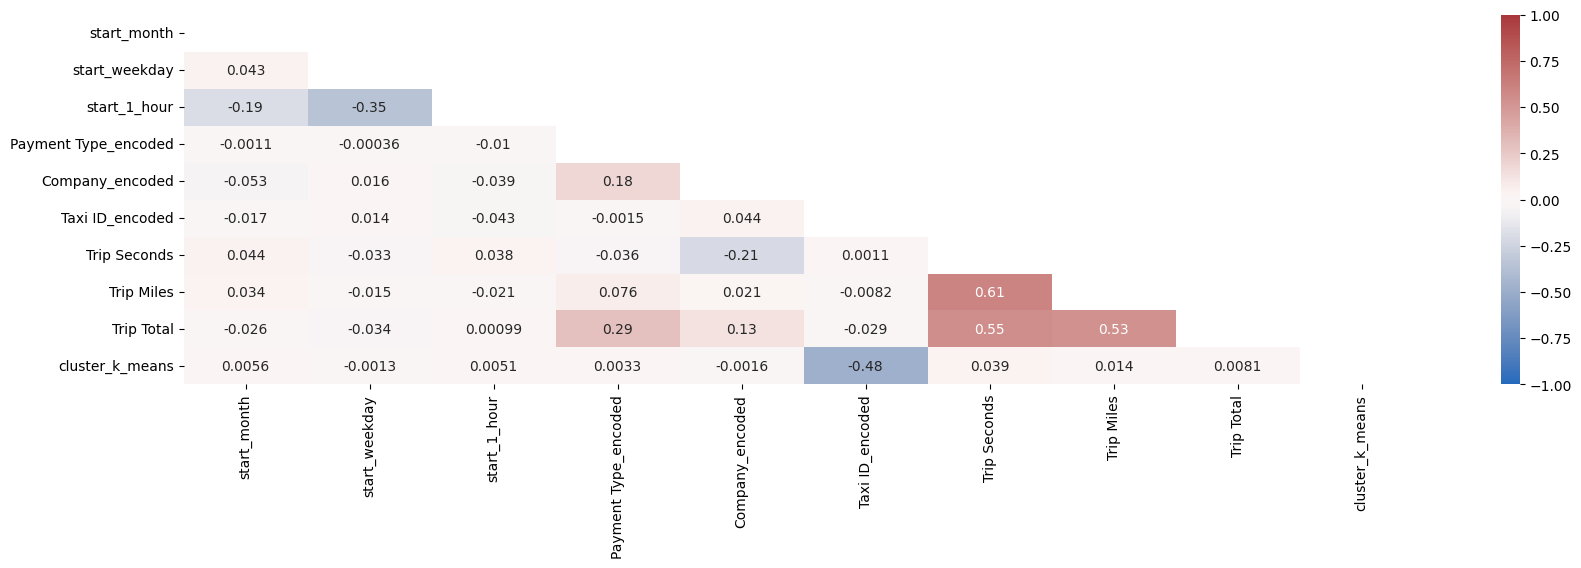

In [107]:
base_df_corr = trip_clustering_df.corr()
mask = np.triu(np.ones_like(base_df_corr, dtype=bool))
f = plt.figure()
f.set_figwidth(20)
f.set_figwidth(20)
sns.heatmap(base_df_corr, annot = True, vmax= 1, vmin= -1, center=0, cmap='vlag', mask = mask)
plt.show()

In [100]:
# scaling trip_df with the go-to scaling in industry
scaler = StandardScaler()
scaler.fit(trip_clustering_unscaled_df)
trip_clustering_scaled = scaler.transform(trip_clustering_unscaled_df)

trip_clustering_scaled_df = pd.DataFrame(trip_clustering_unscaled_df, columns = trip_clustering_unscaled_df.columns, index = trip_clustering_unscaled_df.index)

In [101]:
trip_clustering_scaled_df

,start_month,start_1_hour_sin,start_1_hour_cos,Payment Type_encoded,Company_encoded,Taxi ID_encoded,Trip Seconds,Trip Miles,Trip Total
0,5,0.500000,-8.660254e-01,3,28,294,1080.0,7.0,18.95
1,4,-1.000000,-1.836970e-16,3,28,4672,1080.0,3.0,12.45
2,5,-0.258819,9.659258e-01,4,50,1587,720.0,2.1,11.45
3,5,0.258819,9.659258e-01,4,28,6832,480.0,0.0,11.85
4,4,-0.500000,-8.660254e-01,4,103,1898,0.0,0.0,49.05
...,...,...,...,...,...,...,...,...,...
995,5,-0.866025,5.000000e-01,3,28,2175,300.0,1.1,6.35
996,4,0.500000,-8.660254e-01,4,34,7140,0.0,0.0,8.45
997,4,0.500000,8.660254e-01,4,9,1903,420.0,0.0,10.05
998,5,-0.258819,-9.659258e-01,4,9,854,840.0,0.0,15.65


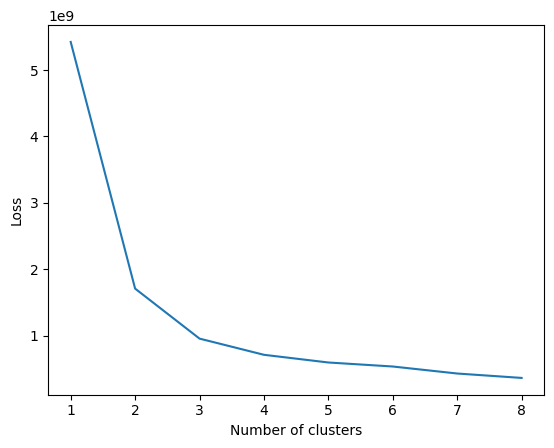

In [102]:
# Grid search for the optimum number of clusters with KMean  
# Source: Data Mining for Business Analytics by Galit Shmueli, Peter C. Bruce, Peter Gedeck, Nitin R. Patel: Chapter 15.10

k_max = 8

clusters = []
losses = []

for k in range(k_max):
    model = KMeans(n_clusters = k + 1, n_init='auto', init="k-means++", random_state=42)
    model.fit(trip_clustering_scaled_df)
    
    clusters.append(k+1)
    losses.append(model.inertia_)
    
# plot grid search result
plt.plot(clusters, losses)
plt.ylabel("Loss")
plt.xlabel("Number of clusters")
plt.show()

In [103]:
trip_model_k_means = KMeans(n_clusters = 3, n_init=10, init="k-means++", random_state=42)
trip_model_k_means.fit(trip_clustering_scaled_df)

trip_clustering_df['cluster_k_means'] = trip_model_k_means.predict(trip_clustering_scaled_df)

In [104]:
trip_clustering_df

,start_month,start_weekday,start_1_hour,Payment Type_encoded,Company_encoded,Taxi ID_encoded,Trip Seconds,Trip Miles,Trip Total,cluster_k_means
0,5,5,10,3,28,294,1080.0,7.0,18.95,1
1,4,3,18,3,28,4672,1080.0,3.0,12.45,2
2,5,5,23,4,50,1587,720.0,2.1,11.45,1
3,5,5,1,4,28,6832,480.0,0.0,11.85,0
4,4,4,14,4,103,1898,0.0,0.0,49.05,1
...,...,...,...,...,...,...,...,...,...,...
995,5,6,20,3,28,2175,300.0,1.1,6.35,1
996,4,4,10,4,34,7140,0.0,0.0,8.45,0
997,4,4,2,4,9,1903,420.0,0.0,10.05,1
998,5,5,13,4,9,854,840.0,0.0,15.65,1


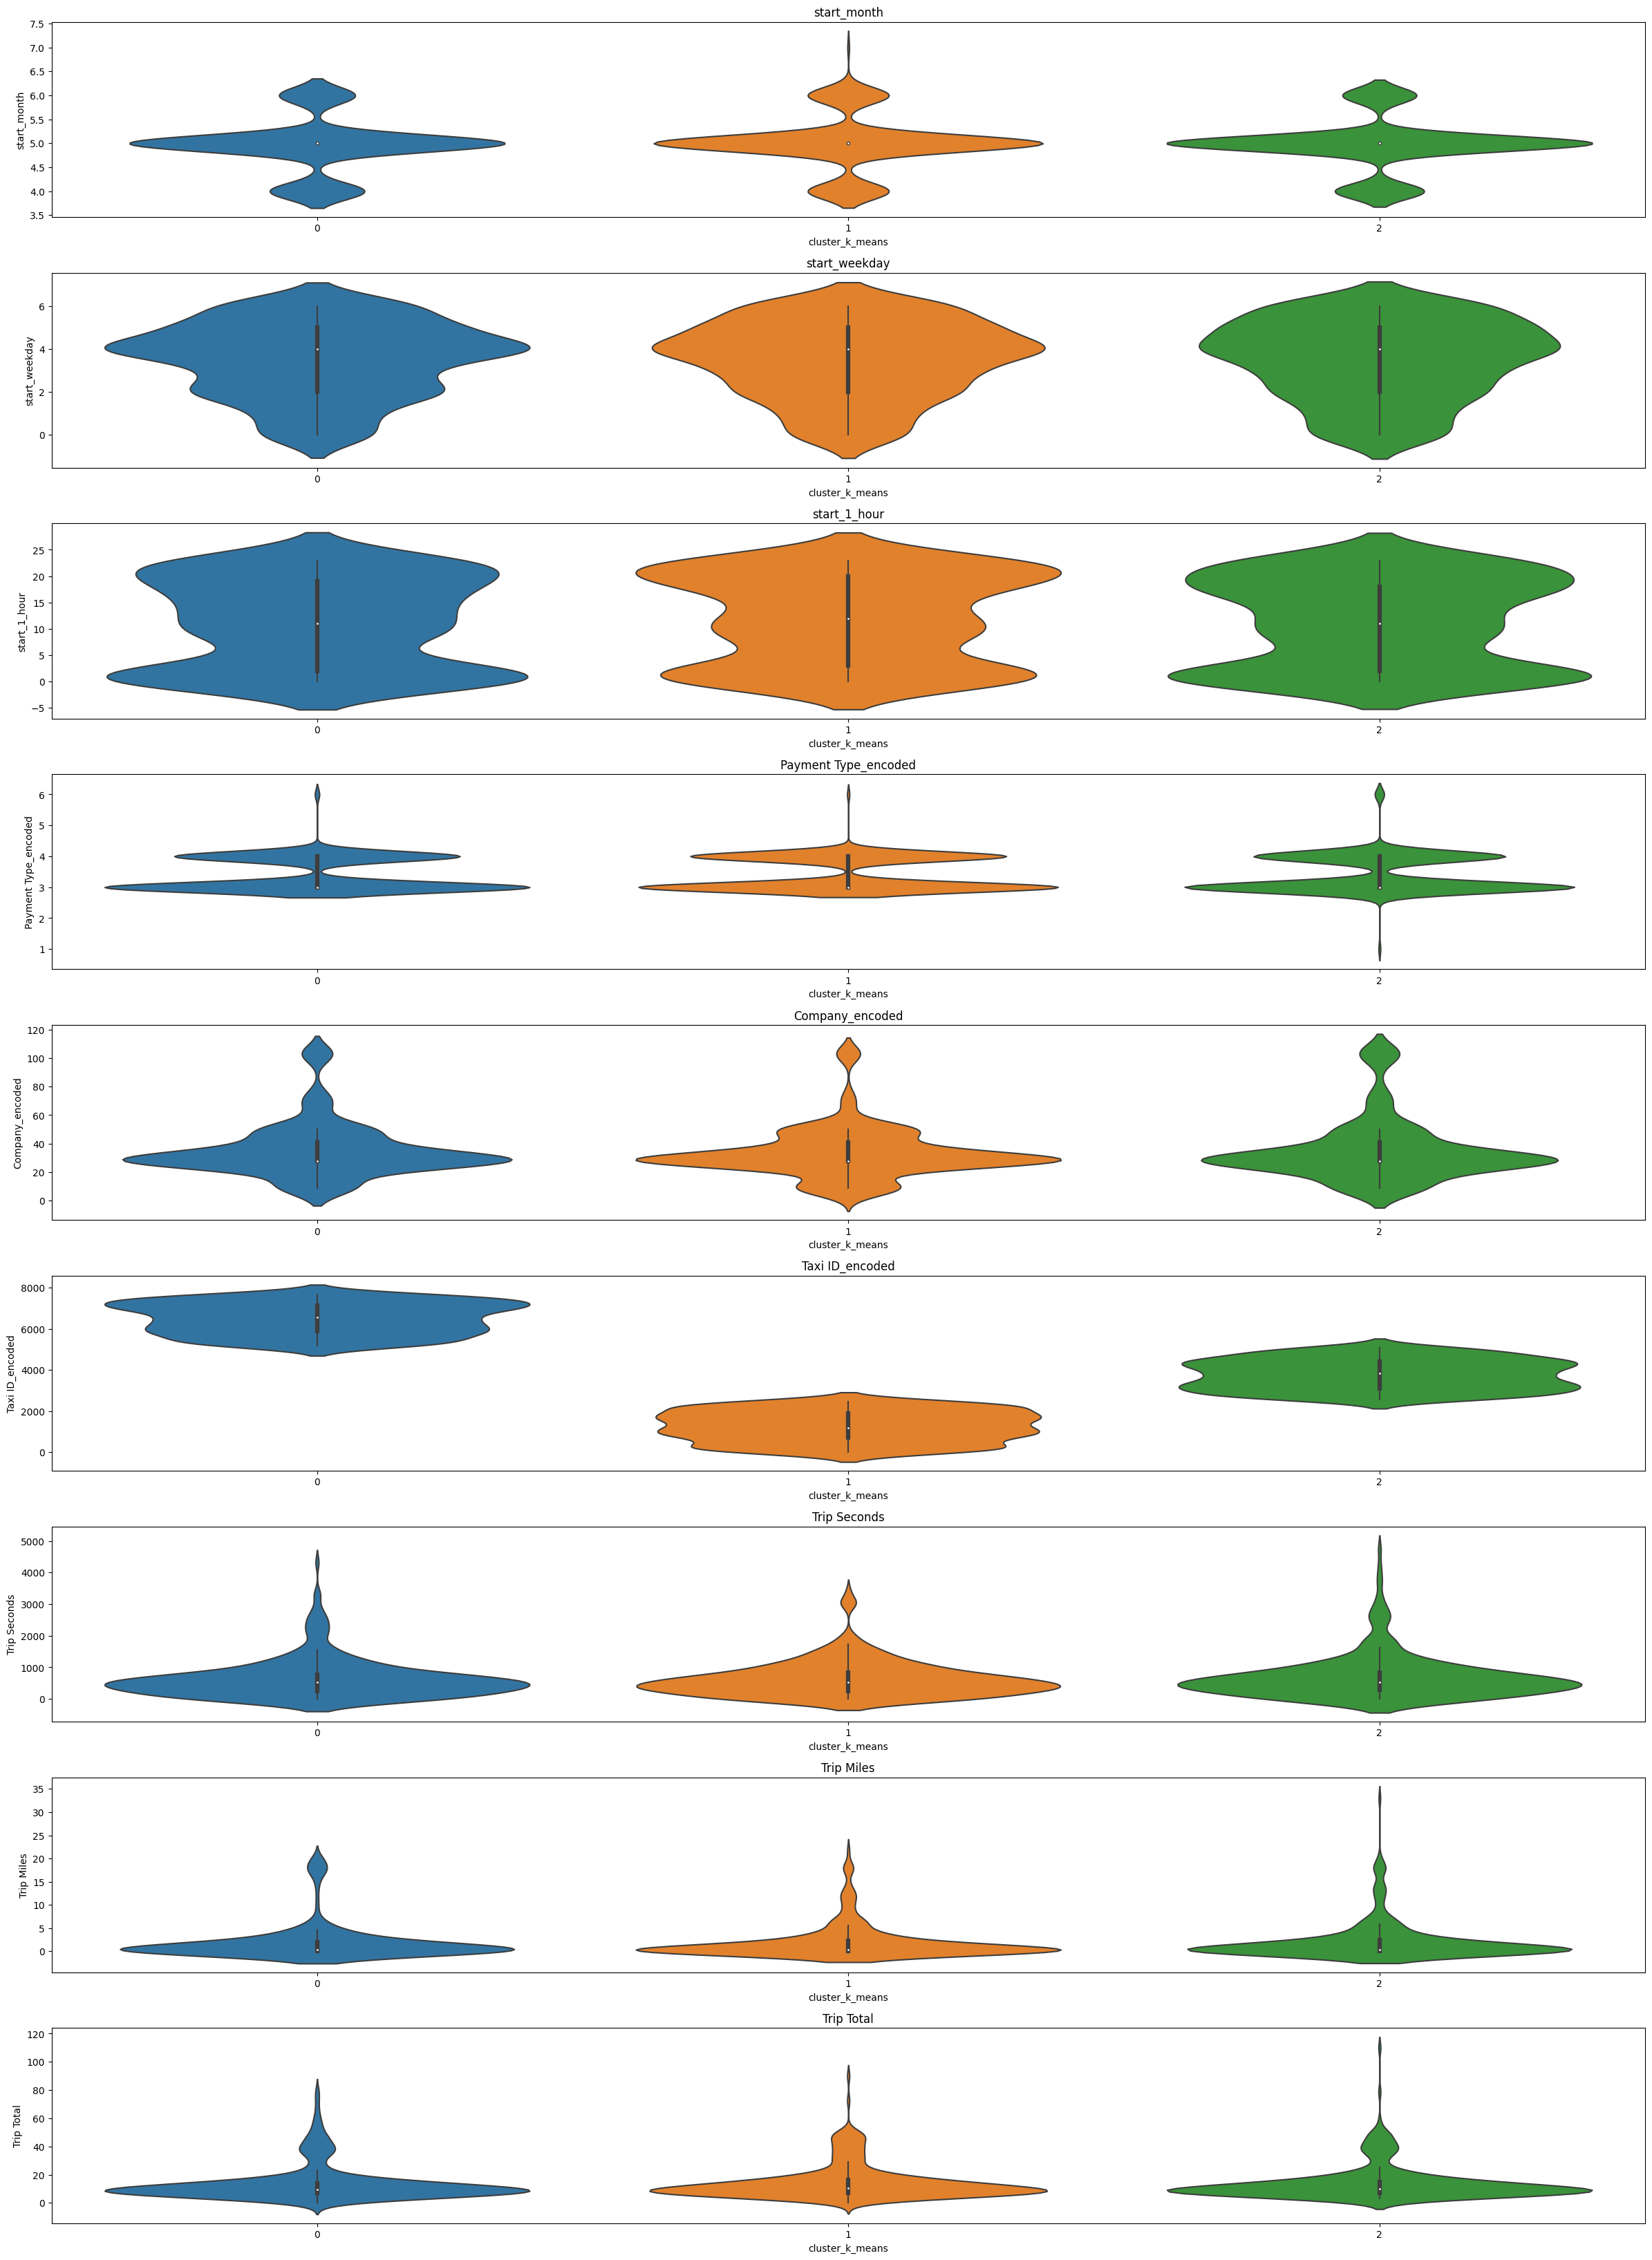

In [105]:
fig = plt.figure(figsize = (24,36))

plot_counter = 1

# iterate over all input features to plot the value distribution across the clusters  
for feat in trip_attributes:
        ax = fig.add_subplot(len(trip_clustering_df.columns), 1, plot_counter)

        sns.violinplot(ax = ax, x=trip_clustering_df['cluster_k_means'], y=trip_clustering_df[feat], data=trip_clustering_df)
        ax.set_title(feat)

        plot_counter += 1

fig.tight_layout()
plt.show() 